# KLayout Scripting Guide

A guide to scripting in KLayout using the Python Library. This guide is inspired by the [PyPi](https://www.klayout.org/klayout-pypi) API. This guide will show you how to generate cells (structures) in KLayout and build nested cells (using a pattern in another pattern).

KLayout allows users to build patterns in a database (GDSII) file, which can be read by the Raith Voyager system. Patterns may be placed in nested cells, which is the equivalent of building a position list, but can also be seen individually within the database allowing users to build a position list using the Raith tool.

## Contents

* [Imports](#imports)
* [Organisation](#organisation)
* [Flat Gratings](#flat-gratings)
    * [Grating Parameters](#grating-parameters)
    * [Database Setup](#database-setup)
    * [Grating Layer](#grating-layer)
    * [Write Out](#write-out)
    * [Results](#result)
* [Hierarchical Gratings](#hierarchical-gratings)
    * [Database Setup](#hierarchical-database-setup)
    * [Grating Cell](#grating-cell)
    * [Results](#hierarchical-result)
    * [Nested Grating Bars](#nested-grating-bars)
    * [Results](#nested-grating-result)
    * [Write Out](#hierarchical-write-out)
* [Rotations and Transformations](#rotations-and-transformations)
    * [Database Setup](#rotations-database-setup)
    * [Grating Cell](#rotations-grating-cell)
    * [Rotating and Transforming](#rotating-and-transforming-cells)
    * [Results](#rotation-grating-results)
    * [Write Out](#rotation-write-out)
* [Mering Layouts](#merging-layouts)
    * [Database Setup](#merging-database-setup)
    * [Import Databases](#import-databases)
    * [Results](#merging-results)
    * [Write Out](#merging-write-out)
* [Writing Text](#writing-text)
    * [Database Setup](#text-database-setup)
    * [Text](#text)
    * [Results](#text-results)
    * [Write Out](#text-write-out)
* [Creating a Chip](#creating-a-chip)
    * [Chip Database Setup](#chip-database-setup)
    * [Flat Grating Generation](#flat-grating-generation)
    * [Flat Grating Cell](#flat-grating-cell)
        * [Dose Factor](#dose-factor-loop)
        * [Fill Factor](#fill-factor-loop)
        * [Period](#period-loop)
        * [Putting Together](#putting-together)
    * [Adding Text](#adding-text)
    * [Adding Cells to Top](#adding-cells-to-top)
    * [Grating Keys](#grating-keys)
    * [Flat Cell Results](#flat-cell-results)
    * [Write Out](#flat-cell-write-out)

## Imports

As is convention when building a python script, we will start by importing the key python libraries required to use the code in this document. The key Python library required is klayout.db.

Remember that Python libraries can be installed using the pip tool, or sudo apt-get on linux devices:

* python -m pip install klayout
* sudo apt-get install python-klayout

Other key libraries required are math, to perform calculations, numpy and pathlib for universal directory paths.

In [118]:
import math
import numpy as np
import klayout.db as db

from pathlib import Path

## Organisation

We will begin by setting up the organisation (directory tree). This directory contains the scripts required to complete the processing and save out to a directory called "Data". This should not need changing, but if you would rather save the database files elsewhere, please adjust the out_path as required.

As we are using pathlib to set our directory paths, this is a simple f-string in python.

[Back To Top](#contents)

In [119]:
root = Path().absolute()
out_path = Path(f'{root}/Data')
print(out_path)

c:\Users\joshs\github\Cleanroom_Toolkit\GDSII_KLayout\Data


## Flat Gratings

Flat gratings are one-dimensional periodic structures with a constant period and fill factor. The most basic of periodic structures. We will begin by setting up the grating parameters and then we will create the individual grating cell and nest with labelling text.

### Grating Parameters

We begin by setting the initial grating parameters, namely the height and width of the overall grating, the grating period, filling factor (i.e., how much of the period is filled with the grating material), and the dose factor (the dose scaling factor used by the Raith system).

In KLayout, the dose factor is scaled differently to the Raith system. The Raith system may use a dose factor of "1", and in KLayout this would be "1000", and "1.2" is "1200" etc. This is a simple scaling factor that we will add later, for now please use the Raith dose factor that you would like to achieve, e.g., "1".

Please note that KLayout defaults to millimeter scaling, but later we will set the database units to micrometers. Hence the following parameters are set to micrometers.

[Back To Top](#contents)

In [120]:
grating_height = 500
grating_width = 500
dose_factor = 1
grating_period = 0.550
fill_factor = 0.7

### Database Setup

Now we will set up the KLayout database to contain our grating structures. We do this using the db.Layout() function, and then set the database units to be micrometers.

As KLayout is a database of cells, we need to give the database a top cell, this can be called whatever you would like, but the convention is to use "TOP". Please change the naming however you would like it to appear.

[Back To Top](#contents)

In [121]:
layout = db.Layout()
layout.dbu = 0.001  # millimeters to micrometers
top_cell = layout.create_cell("TOP")
top_layer = layout.layer(1, dose_factor * 1000)

### Grating Layer

Now that we have a cell called "TOP", we want to start building our grating. We start by finding the number of periods in the grating width as a whole number, then we create a database point (the bottom left point of the grating). From this point we extend the box as a vector of the width and height of the grating bar.

Finally, we add the shape to the grating layer and repeat for the number of boxes in the total grating width. We are just going to add our grating to the top cell directly, later on we will discuss nesting cells.

Recall that the filling factor is the area of the period filled by the grating and that writing into positive photoresist is writing the air, so we need to introduce a (1-fill_factor) into the calculation.

You will see that we start the grating point at a number (i) multiplied by the grating period, and then extend this point to create a box using the database vector.

[Back To Top](#contents)

In [122]:
number_of_boxes = math.floor(grating_width / grating_period)
for i in range(0, number_of_boxes):
    starting_point = db.DPoint(i * grating_period, 0)
    grating_box = db.DBox(
        starting_point,
        (
            starting_point +
            db.DVector(grating_period * (1 - fill_factor), grating_height)
        )
    )
    top_cell.shapes(top_layer).insert(grating_box)

### Write Out

Now we have built the grating structure and we want to write it out and save as a database file. For the purpose of this guide, I will use the file name "Example_FlatGratings.gds", and all this should contain is a cell called "TOP1" with a grating of 550nm period in a 500x500 micrometer square. The grating should have a fill factor of 0.7, which will be the white area in KLayout, the written boxes (pink/purple) in colour, will be 0.3 fill factor.

[Back To Top](#contents)

In [123]:
layout.write(f'{out_path}/Example_FlatGratings.gds')

### Result

The result should be something that looks like this:

![Example_FlatGratings.png](./src/Images/Example_FlatGratings.png)

A flat grating of period 550nm with a total grating size of 500x500um, and in a cell called "TOP".

[Back To Top](#contents)

## Hierarchical Gratings

Now we will discuss nesting cells inside another cell. You may be familiar with the Hierarchy system, or nested system, or layered system. Essentially we are going to build a basic structure in a cell as before, but then we are going to nest that cell within a higher cell, and repeat the structure to create a grating.

Again, we will only consider flat gratings in this section.

### Hierarchical Database Setup

Now we will set up the KLayout database to contain our grating structures. We do this in the same way as before with db.Layout() and we create a top cell, named "TOP". Here we have not defined a layer or dose, as this will be done within the grating cell. Note that we have set the database units to um.

[Back To Top](#contents)

In [124]:
layout = db.Layout()
layout.dbu = 0.001
top_cell = layout.create_cell("TOP")

### Grating Cell

Now that we have a top cell and a database, we can begin by setting up the grating cell, before inserting it into the top cell.

We create a new cell, specifically for the grating, named "Grating" and apply a layer to that cell with the dose factor and dose factor scaling of 1000 as before. Then we create the grating, in much the same was as in [Grating Layer](#grating-layer) but we apply the grating to the grating cell.

Once we have got the grating, we add the grating cell to the top cell using the .insert() function and giving it a translational vector. Because we began the grating at (0, 0) in the grating cell, we are moving the (0, 0) position using this grating. For now, we will not move the grating in the top cell, hence the vector is given a (0, 0).

[Back To Top](#contents)

In [125]:
grating_cell = layout.create_cell("Grating")
grating_layer = layout.layer(1, dose_factor * 1000)
number_of_boxes = math.floor(grating_width / grating_period)
for i in range(0, number_of_boxes):
    starting_point = db.DPoint(i * grating_period, 0)
    grating_box = db.DBox(
        starting_point,
        (
            starting_point +
            db.DVector(grating_period * (1 - fill_factor), grating_height)
        )
    )
    grating_cell.shapes(grating_layer).insert(grating_box)
top_cell.insert(
    db.DCellInstArray(
        grating_cell.cell_index(),
        db.DTrans(
            db.DVector(0, 0)
        )
    )
)

cell_index=1 r0 0,0

### Hierarchical Result

The result should be something that looks like this:

![Example_FlatGratings.png](./src/Images/Example_HierarchicalGratings.png)

A flat grating of period 550nm with a total grating size of 500x500um, and in a cell called "Grating" which is nested in the "TOP" cell.

### Nested Grating Bars

Taking this a step further, what if we build the grating bar and nest it within the grating cell which is further nested in the top cell?

We start by building a bar_cell and giving it its own dose, this is purely for appearance in the example database as the two will appear as different colours. We build the bar by giving it a starting point, where here we have arbitrarily given it a (0, 0) starting point, and then we give it a vector as the grating period multiplied by (1 - fill factor), and the grating height. Then we add the bar shape to the bar cell, in much the same fashion as before. Then we use the same formulation to add the bar cell to the grating cell in a periodic repetition, finally adding the grating cell to the top cell as before.

Here I have added the second grating to the top cell at a 600um spacing to the first grating so that both are visible in the top cell. This is the same method that will be used to create rows of gratings going forward.

[Back To Top](#contents)

In [126]:
bar_cell = layout.create_cell("Bar")
bar_layer = layout.layer(2, dose_factor * 1000)
starting_point = db.DPoint(0, 0)
grating_bar = db.DBox(
    starting_point,
    (
        starting_point +
        db.DVector(grating_period * (1 - fill_factor), grating_height)
    )
)
bar_cell.shapes(bar_layer).insert(grating_bar)
grating_cell2 = layout.create_cell("Grating_2")
x_vector = db.DVector(grating_period, 0)
number_of_boxes = math.floor(grating_width / grating_period)
for i in range(0, number_of_boxes):
    grating_cell2.insert(
        db.DCellInstArray(
            bar_cell.cell_index(),
            db.DTrans(
                i * grating_period,
                0
            )
        )
    )
top_cell.insert(db.DCellInstArray(grating_cell2.cell_index(), db.DTrans(db.DVector(600, 0))))

cell_index=3 r0 600000,0

### Nested Grating Result

Now we see two gratings, spaced by 600um, where grating 2 is a nested cell or bars repeated to make the grating. While this is not immensely useful as most people will want to create a grating in one cell, it can be useful for other design files.

![Example_FlatGratings.png](./src/Images/Example_HierarchicalGratings2.png)

### Hierarchical Write Out

Now we have built the grating cell and applied it to the top cell, we want to write out. This is much the same as before, but I will call this "Example_HierarchicalGratings.gds". This should create a cell called "TOP" under which there is a cell called "Grating" into which we wrote our grating pattern, with period, fill factor, and dose as detailed above.

[Back To Top](#contents)

In [127]:
layout.write(f'{out_path}/Example_HierarchicalGratings.gds')

## Rotations and Transformations

What if we want to change the orientation of a grating, so that instead of the bars running vertically as they have done in previous examples, they now run horizontally, or at any angle?

Again, we will only consider flat gratings in this section.

### Rotations Database Setup

Now we will set up the KLayout database to contain our grating structures. We do this in the same way as before, creating a top cell, named "TOP", and defining the database units as um.

[Back To Top](#contents)

In [128]:
layout = db.Layout()
layout.dbu = 0.001
top_cell = layout.create_cell("TOP")

### Rotations Grating Cell

Now that we have a top cell and a database, we can begin by setting up the grating cell, before inserting it into the top cell.

Here we will use only one grating cell, and we will then apply four copies of this to the top cell to demonstrate the complex transformations. We have used the bar cell and period inserts to create a nested grating cell. Note that here we have not inserted the grating cell into the top cell.

[Back To Top](#contents)

In [129]:
bar_cell = layout.create_cell("Bar")
bar_layer = layout.layer(1, dose_factor * 1000)
starting_point = db.DPoint(0, 0)
grating_bar = db.DBox(
    starting_point,
    (
        starting_point +
        db.DVector(grating_period * (1 - fill_factor), grating_height)
    )
)
bar_cell.shapes(bar_layer).insert(grating_bar)
grating_cell = layout.create_cell("Grating")
x_vector = db.DVector(grating_period, 0)
number_of_boxes = math.floor(grating_width / grating_period)
for i in range(0, number_of_boxes):
    grating_cell.insert(
        db.DCellInstArray(
            bar_cell.cell_index(),
            db.DTrans(
                i * grating_period,
                0
            )
        )
    )

### Rotating and Transforming Cells

To rotate and transform a cell, we use the db.ICplxTrans() function which takes the arguments (scale, rotation, mirror, x, y). Here we have used clear variable names to indicate their purpose. Once complete, we then insert the grating cell into the top cell as before, and supply the transformations or rotations in the DCellInstArray() function.

[Back To Top](#contents)

In [130]:
rotation_angle_1 = 90
rotation_angle_2 = 45
scale_factor_1 = 1
scale_factor_2 = 2
mirror = False
transform_1 = db.ICplxTrans(scale_factor_1, 0, mirror, 0, 0)
transform_2 = db.ICplxTrans(scale_factor_1, rotation_angle_1, mirror, 1100, 0)
transform_3 = db.ICplxTrans(scale_factor_1, rotation_angle_2, mirror, 1600, 0)
transform_4 = db.ICplxTrans(scale_factor_2, 0, mirror, 2200, 0)
top_cell.insert(db.DCellInstArray(grating_cell.cell_index(), transform_1))
top_cell.insert(db.DCellInstArray(grating_cell.cell_index(), transform_2))
top_cell.insert(db.DCellInstArray(grating_cell.cell_index(), transform_3))
top_cell.insert(db.DCellInstArray(grating_cell.cell_index(), transform_4))

cell_index=2 r0 *2 2200000,0

### Rotation Grating Results

Now we should see four gratings, one as the original, one rotated by 90 degrees (note the difference in coordinates from the rotation), one rotated by 45 degrees, and one scaled by a factor 2 (note that this increases all dimensions by a factor 2, so the bar width and period have also scaled by a factor 2).

![Example_TransformationGratings.png](./src/Images/Example_TransformationGratings.png)

### Rotation Write Out

Now we have built the grating cell and applied it to the top cell with the rotations and transformations, we want to write out. This is done exactly as before, but I will call this "Example_TransformationGratings.gds". This should create a cell called "TOP" under which there is a cell called "Grating" into which we wrote our grating pattern, with period, fill factor, and dose as detailed above.

[Back To Top](#contents)

In [131]:
layout.write(f'{out_path}/Example_TransformationGratings.gds')

## Merging Layouts

What if we have some cells in a KLayout database that we like and we want to put them into another KLayout database? Fortunately, we can merge database cells together and translate them in much the same way we can with individual cells in a higher hierarchy cell.

### Merging Database Setup

Once again, we create a KLayout database with a top cell called "TOP", but here we have not changed the database units to um. Instead we are going to insert the three previously generated database files and insert them spaced 1mm apart in the vertical direction.

[Back To Top](#contents)

In [132]:
layout = db.Layout()
top_cell = layout.create_cell("TOP")
spacing_y = 2.0

### Import Databases

Note that this process doesn't seem to like file paths, so it is recommended to copy the databases into the same directory as this script to make it work.

Here we have given a list of the previously generated database files and some names. Using a simple for loop, we can read the files in, import the top cells, import the cell tree, remove resources once they are no longer required using "_destroy", and then space the imported databases using the for loop and spacing parameter detailed above.

[Back To Top](#contents)

In [133]:
file_list = [
    'Example_FlatGratings.gds',
    'Example_HierarchicalGratings.gds',
    'Example_TransformationGratings.gds'
]
file_names = [
    "Flat",
    "Hierarchical",
    "Transformation"
]
initial_y = 0.0
for index, file in enumerate(file_list):
    layout_import = db.Layout()
    layout_import.read(file)
    imported_top_cell = layout_import.top_cell()
    target_cell = layout.create_cell(file_names[index])
    target_cell.copy_tree(imported_top_cell)
    layout_import._destroy()
    insert = db.DCellInstArray(
        target_cell.cell_index(),
        db.DTrans(
            db.DVector(
                0,
                initial_y
            )
        )
    )
    top_cell.insert(insert)
    initial_y += target_cell.dbbox().height() + spacing_y

### Merging Results

The result is a hierarchical tree containing the three database files. Within each database file is the construction cells, layers, and shapes we created earlier.

![Example_Merging.png](./src/Images/Example_Merging1.png)

Increasing the hierarchy viewing we can see the resulting shapes.

![Example_Merging2.png](./src/Images/Example_Merging2.png)

### Merging Write Out

Writing out is completed in the same fashion as before, here I have called the file "Example_Merging.gds". Note that the other database files are not in the main directory, without which the code will not run.

[Back To Top](#contents)

In [134]:
layout.write(f'{out_path}/Example_Merging.gds')

## Writing Text

Writing grating descriptions, identifiers, or any other text is a key element of creating lithographic structures. So let's look at how we can write text, and what sizes to use, in KLayout.

### Text Database Setup

Create the database setup in the same way as before and set the database units to micrometers.

[Back To Top](#contents)

In [135]:
layout = db.Layout()
layout.dbu = 0.001
top_cell = layout.create_cell("TOP")

### Text

We want to be able to read the text under a microscope. Fortunately, KLayout scripting allows us to change the text magnification. Unfortunately, the units are not obvious. We will generate multiple text elements of different sizes and check their physical size in the resulting database.

Use the TextGenerator module of the KLayout library to write text. We will write the text magnification as a number and insert directly into the top cell for now. We will space the text in x by indexing the text_magnification array.

[Back To Top](#contents)

In [136]:
text_magnifications = range(5, 105, 5)
text_generator = db.TextGenerator.default_generator()
text_layer = layout.layer(1, 1000)
for index, text_size in enumerate(text_magnifications):
    text_region = text_generator.text(
        f'{text_size}',
        layout.dbu,
        text_size)
    top_cell.shapes(text_layer).insert(
        text_region,
        db.DTrans(
            db.DVector(
                index * 125,
                0
            )
        )
    )

### Text Results

The result is a series of numbers that increase in size. We will now measure their size and create a graph.

![Example_Text.png](./src/Images/Example_Text.png)

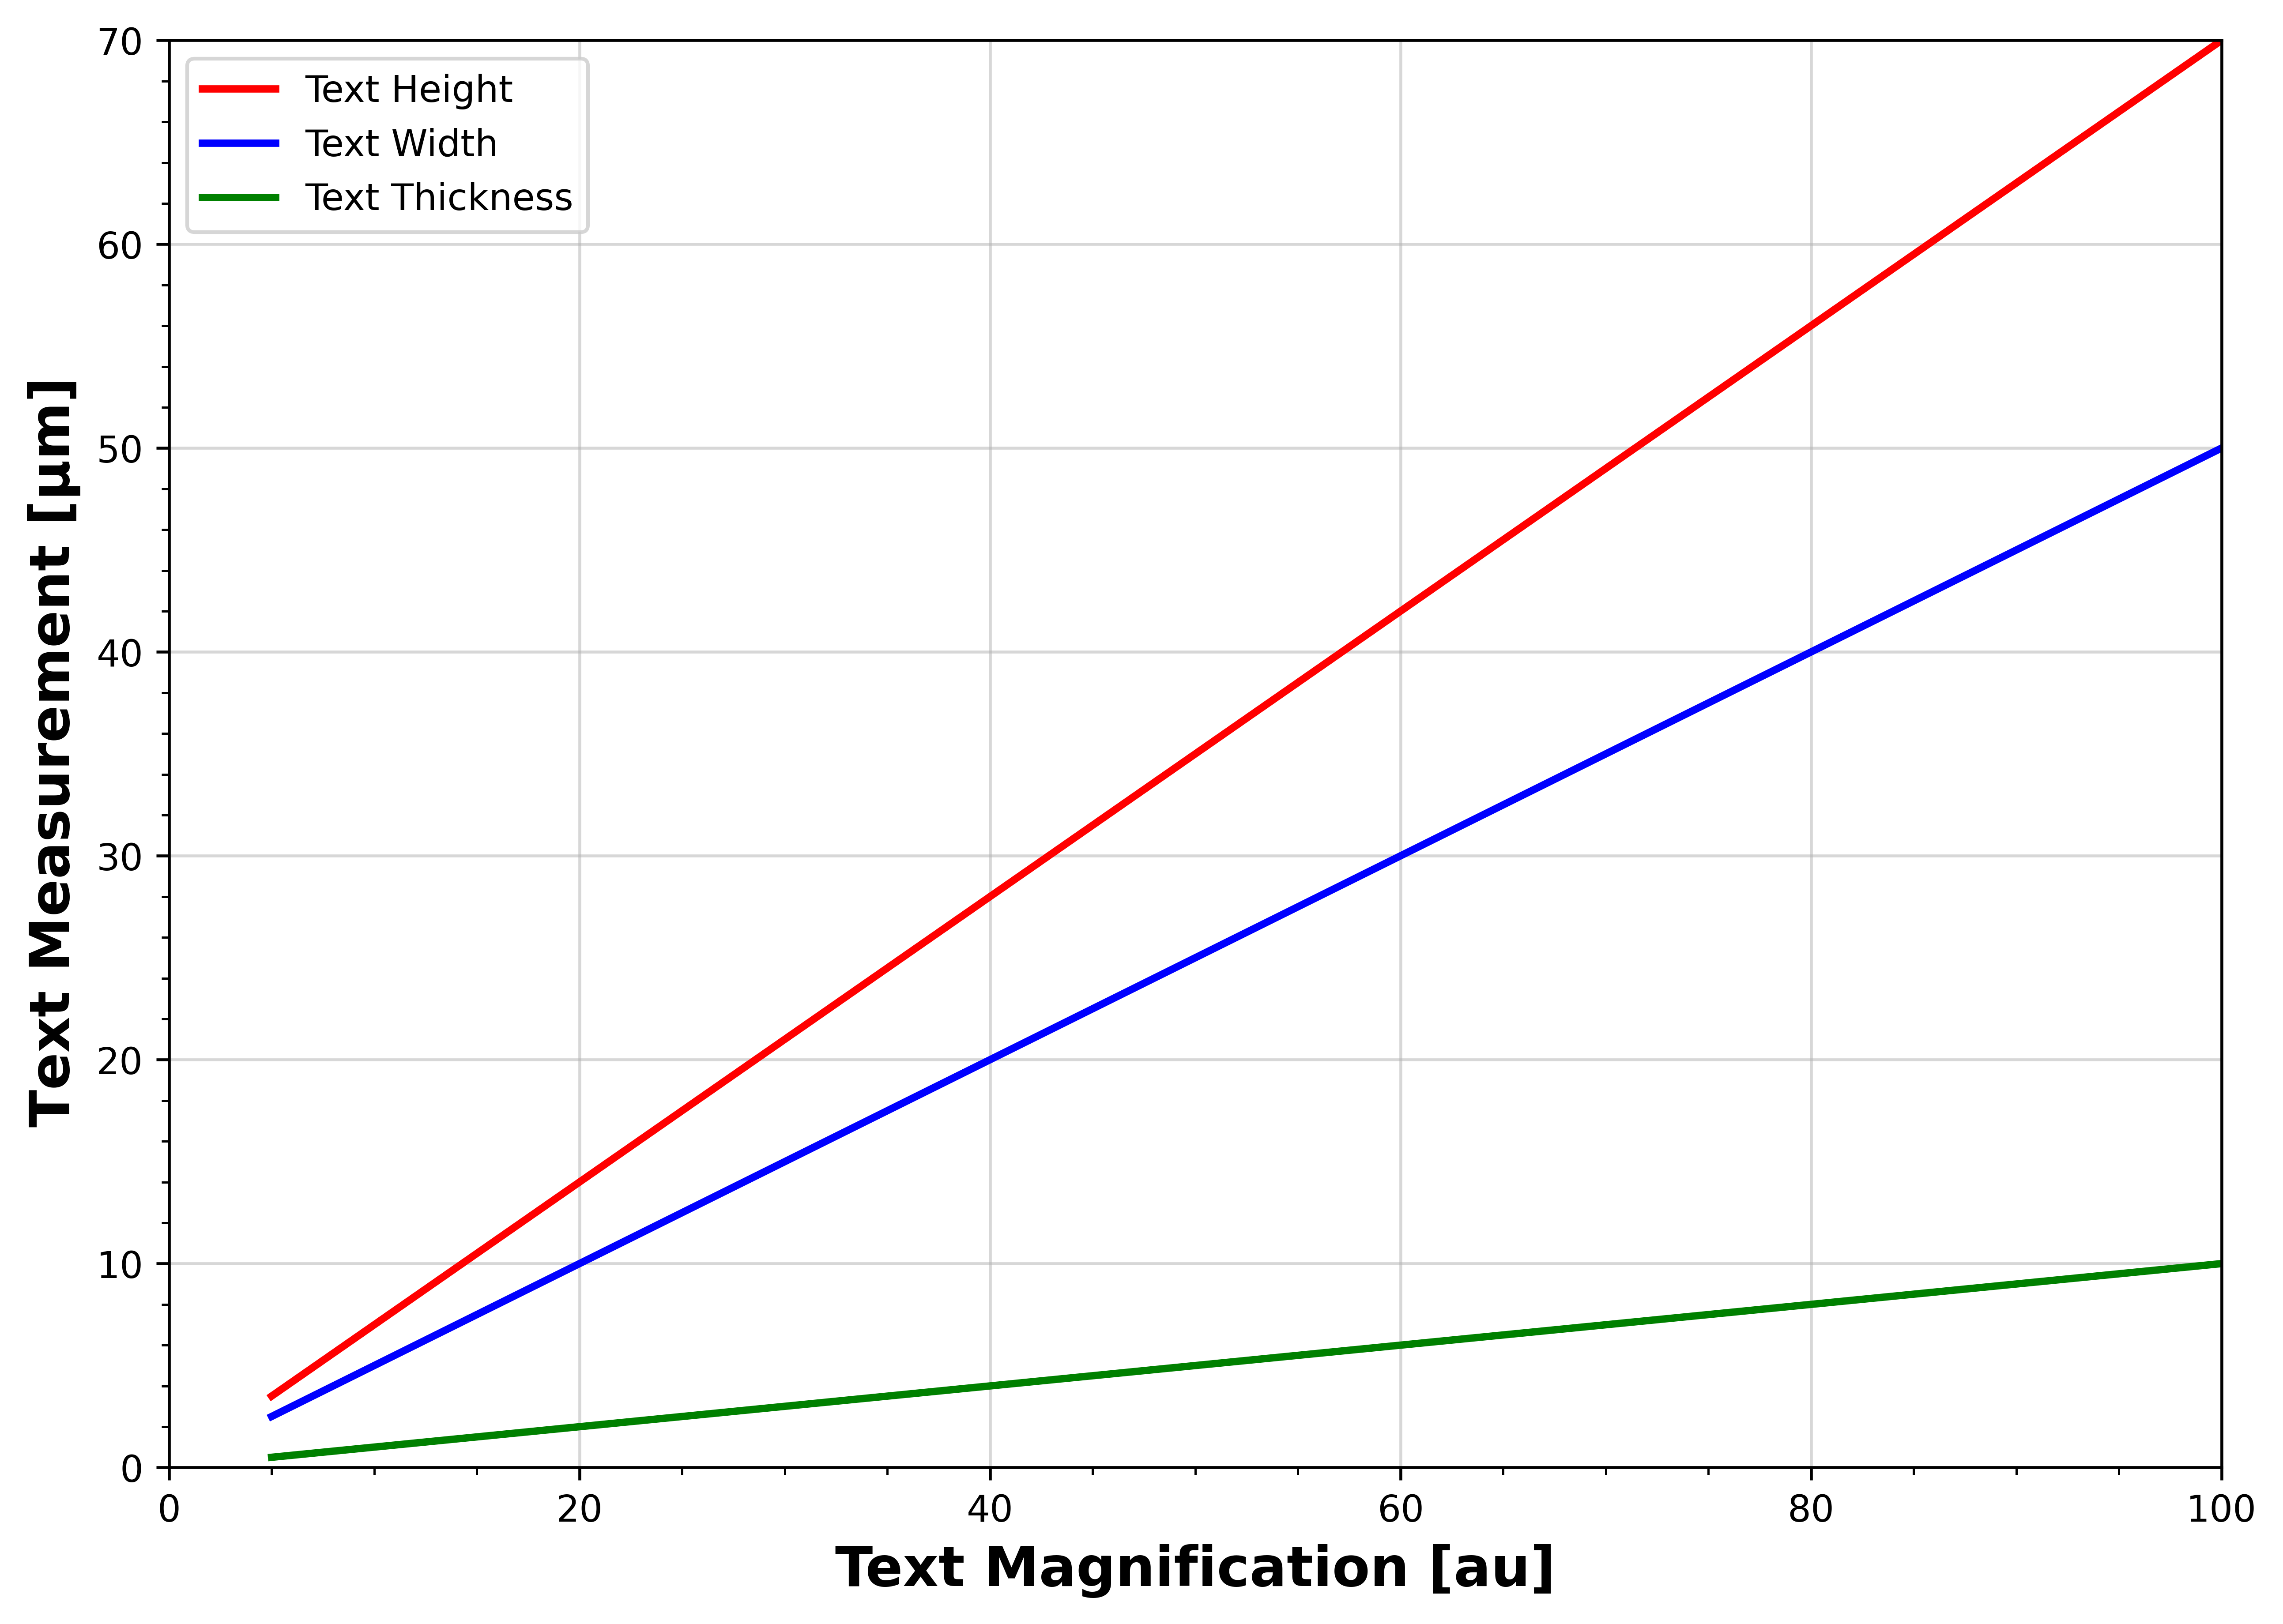

In [152]:
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoMinorLocator

height = [
    3.5, 7, 10.5, 14, 17.5, 21, 24.5, 28, 31.5, 35, 38.5, 42, 45.5, 49, 52.5,
    56, 59.5, 63, 66.5, 70]
width = [
    2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40,
    42.5, 45, 47.5, 50]
thickness = [
    0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5,
    10]
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=[10, 7],
    dpi=600)
ax.plot(
    text_magnifications,
    height,
    'r',
    lw=2,
    label='Text Height'
)
ax.plot(
    text_magnifications,
    width,
    'b',
    lw=2,
    label='Text Width'
)
ax.plot(
    text_magnifications,
    thickness,
    'g',
    lw=2,
    label='Text Thickness'
)
ax.legend(
    frameon=True,
    loc=0,
    prop={'size': 10}
)
ax.set_xlabel(
    'Text Magnification [au]',
    fontsize=15,
    fontweight='bold'
)
ax.set_ylabel(
    r'Text Measurement [$\bf{\mu}$m]',
    fontsize=15,
    fontweight='bold'
)
ax.grid(
    True,
    which='major',
    alpha=0.5
)
ax.set_xlim(0, 100)
ax.set_ylim(0, 70)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()


### Text Write Out

Write out in the same way as before. I have called the file "Example_Text.gds".

[Back To Top](#contents)

In [137]:
layout.write(f'{out_path}/Example_Text.gds')

## Creating a Chip

Now let's combine everything to create a chip containing multiple gratings, we will also add text so that we can identify each grating and determine the grating dimensions.

### Chip Database Setup

Create the database setup in the same way as before and set the database units to micrometers.

[Back To Top](#contents)

In [138]:
layout = db.Layout()
layout.dbu = 0.001


### Flat Grating Generation

We will start by generating some flat gratings to go on our chip, this is the same process as before, but we will do this in a loop and generate the text that describes the gratings for later use. We will generate some grating periods, fill factors, and dose factors below.

First, generate the grating parameter ranges, sample identifier string (this could be any string), and the grating dimensions. Here I have used the standard 500x500um grating.

[Back To Top](#contents)

In [139]:
sample_identifier = "Chip"
top_cell = layout.create_cell(f'{sample_identifier}')
period_range = range(300, 801, 50)
fill_factor_range = np.arange(0.6, 0.81, 0.1)
dose_factor_range = np.arange(0.5, 2.1, 0.5)
grating_height = 500
grating_width = 500
text_spacing = 75
grating_spacing = 500

### Flat Grating Cell

We will create the gratings using loops for the period, fill factor, and dose ranges above and nest each grating in a cell for fill factor and dose ranges.

#### Dose Factor Loop

Begin by setting up a cell for flat gratings, called "Flat_Gratings", and loop through the dose factor range. The range is indexed to allow for algorithmic spacing of the gratings. The dose factor affects the layer dose, so this is set first, and then each loop has its own identifier string so that the cells can have unique names. The dose factor loop sits at the top so that we can space groups of gratings at different doses more easily.

#### Fill Factor Loop

The fill factor loop is next, with each fill factor group having its own unique identifier string and cell. The cell contains gratings with different periods and the same fill factor. Again the loop is index for easier algorithmic spacing.

#### Period Loop

It is within the period loop that the grating is constructed, in much the same way as before. Starting by setting up a singular grating bar, and then extending using the period into a full grating.

#### Putting Together

Nesting the individual loops is achieved by inserting the spacing dimensions, and the vector for spacing the nested cells in the flat cell.

[Back To Top](#contents)

In [140]:
flat_cell = layout.create_cell('Flat_Gratings')
for i, dose in enumerate(dose_factor_range):
    layer = layout.layer(i, dose * 1000)
    dose_identifier = f'df{dose}'
    dose_cell = layout.create_cell(f'DF_{dose_identifier}')
    for j, ffs in enumerate(fill_factor_range):
        ff = round(ffs, 1)
        row_identifier = f'df{dose}_ff{ff}'
        ff_cell = layout.create_cell(f'FF_{row_identifier}')
        for k, period in enumerate(period_range):
            grating_period = period / 1000
            grating_identifier = f'df{dose}_ff{ff}_p{period}'
            bar_cell = layout.create_cell(f'Bar_{grating_identifier}')
            bar_origin = db.DPoint(0, 0)
            grating_bar = db.DBox(
                bar_origin,
                (
                    bar_origin +
                    db.DVector(
                        grating_period * (1 - ff),
                        grating_height
                    )
                )
            )
            bar_cell.shapes(layer).insert(grating_bar)
            number_of_bars = math.floor(grating_width / grating_period)
            grating_cell = layout.create_cell(f'Grating_{grating_identifier}')
            for n in range(0, number_of_bars):
                grating_cell.insert(
                    db.DCellInstArray(
                        bar_cell.cell_index(),
                        db.DTrans(
                            n * grating_period,
                            0
                        )
                    )
                )
            ff_cell.insert(
                db.DCellInstArray(
                    grating_cell.cell_index(),
                    db.DTrans(
                        db.DVector(
                            k * (grating_width + grating_spacing),
                            0
                        )
                    )
                )
            )
        dose_cell.insert(
            db.DCellInstArray(
                ff_cell.cell_index(),
                db.DTrans(
                    db.DVector(
                        0,
                        j * (grating_height + grating_spacing)
                    )
                )
            )
        )
    flat_cell.insert(
        db.DCellInstArray(
            dose_cell.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (
                        (grating_height * len(fill_factor_range)) +
                        (grating_spacing * len(fill_factor_range))
                    )
                )
            )
        )
    )

### Adding Text

We want the individual gratings to be identifiable under microscope. We have already given the gratings individual labels and stored them in the gratings dictionary above. Now we can use those to label the individual gratings with text. Firstly, however, we will create the grating labels individually.

First we start by defining the text magnification and the generator function. For gratings of size 500x500um, a magnification of 50 is sufficient, and it easily observable under optical microscope. Then, as with the gratings, we will divide the for loops up and repeat the nesting of cells using the algorithmic spacings.

Finally, we are going to create a dictionary, called "Gratings" which will allow us to write the text as a key somewhere else on the chip that does not interfere with the grating region.

[Back To Top](#contents)

In [141]:
text_magnification = 50
generator = db.TextGenerator.default_generator()
flat_cell_text = layout.create_cell("Flat_Gratings_Text")
text_layer = layout.layer(len(dose_factor_range) + 1, 2000)
gratings = {}
for i, dose in enumerate(dose_factor_range):
    dose_identifier = f'df{dose}'
    dose_cell_text = layout.create_cell(f'DF_{dose_identifier}_Text')
    for j, ffs in enumerate(fill_factor_range):
        ff = round(ffs, 1)
        row_identifier = f'df{dose}_ff{ff}'
        ff_cell_text = layout.create_cell(f'FF_{row_identifier}_Text')
        for k, period in enumerate(period_range):
            grating_identifier = f'df{dose}_ff{ff}_p{period}'
            grating_number = f'{sample_identifier}.{i}.{j}.{k}'
            gratings.update({grating_number: grating_identifier})
            grating_cell_text = layout.create_cell(f'Grating_{grating_identifier}_Text')
            region = generator.text(
                grating_number,
                layout.dbu,
                text_magnification)
            grating_cell_text.shapes(text_layer).insert(
                region,
                db.DTrans(
                    db.DVector(
                        0,
                        grating_height + text_spacing
                    )
                )
            )
            ff_cell_text.insert(
                db.DCellInstArray(
                    grating_cell_text.cell_index(),
                    db.DTrans(
                        db.DVector(
                            k * (grating_width + grating_spacing),
                            0
                        )
                    )
                )
            )
        dose_cell_text.insert(
            db.DCellInstArray(
                ff_cell_text.cell_index(),
                db.DTrans(
                    db.DVector(
                        0,
                        j * (grating_height + grating_spacing)
                    )
                )
            )
        )
    flat_cell_text.insert(
        db.DCellInstArray(
            dose_cell_text.cell_index(),
            db.DTrans(
                db.DVector(
                    0,
                    i * (
                        (grating_height * len(fill_factor_range)) +
                        (grating_spacing * len(fill_factor_range))
                    )
                )
            )
        )
    )

### Adding Cells to Top

Adding cells to the top cell is as simple as as has been demonstrated in the previous sections. Here we have aligned the cells to (0, 0) and they can be placed on top of each other.

[Back To Top](#contents)

In [142]:
top_cell.insert(
    db.DCellInstArray(
        flat_cell.cell_index(),
        db.DTrans(
            0,
            0
        )
    )
)
top_cell.insert(
    db.DCellInstArray(
        flat_cell_text.cell_index(),
        db.DTrans(
            0,
            0
        )
    )
)

cell_index=282 r0 0,0

### Grating Keys

Using the gratings dictionary made above, we can write up a key to be placed somewhere on the chip so that we know what each grating is. Again this is only valid for flat gratings as the dictionary is populated during the creation of flat gratings.

The text settings are exactly the same as before.

[Back To Top](#contents)

In [143]:
key_cell = layout.create_cell("Flat_Gratings_Key")
all_keys = gratings.keys()
for index, key in enumerate(all_keys):
    text_string = f'{key} = {gratings[key]}'
    region = generator.text(
        text_string,
        layout.dbu,
        text_magnification
    )
    key_cell.shapes(text_layer).insert(
        region,
        db.DTrans(
            db.DVector(
                0,
                index * text_spacing
            )
        )
    )
top_cell.insert(
    db.DCellInstArray(
        key_cell.cell_index(),
        db.DTrans(
            db.DVector(
                len(period_range) * (grating_width + grating_spacing),
                0
            )
        )
    )
)

cell_index=431 r0 11000000,0

### Flat Cell Results

The result is a hierarchical tree containing gratings with different dose factors, fill factors, and periods, arranged in an algebraic grid with individual labels. The labels correspond to the dose factor, fill factor, and period and are labelled in a key next to the gratings.

![Example_Chip.png](./src/Images/Example_Chip.png)

### Flat Cell Write Out

Once again, the write out process is the same, this time the file is called "Example_Chip.gds".

In [144]:
layout.write(f'{out_path}/Example_Chip.gds')